**Model Synopsis**:  
This model predicts whether a given currency will break out of it's  
current low. It is designed to aid in trend reversals and help filter  
false breakouts. 

**Model Structure**:
As currently constructed, the model contains an input layer with  
the number of neurons equal to the number of columns in the dataset.  
It then contains four hidden layers with ReLU activation functions  
and an output layer with a sigmoid activation function.

**Model Accuracy**:
The model currently has a train accuracy of 0.90 and a test accuracy  
of 0.86.

In [85]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow import keras
import sklearn as sk

# keras functions to use
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from sklearn.utils import class_weight

import warnings  
warnings.filterwarnings('ignore')

In [86]:
data = pd.read_csv('breakout.csv') # read csv file of trades
data.head()

,pair,frame,rg,h,l,c1,c2,c3,supp,o_s,p_s,obv1,obv2,obv3,rsi1,rsi2,rsi3,natr,cyc,result
0,EUR_JPY,H4,31,133.5480,132.77600,133.08700,133.53500,133.84800,133.27900,0.002289,-0.005794,1.661594,1.768208,1.845041,40.720196,47.927515,54.144824,0.324675,3.475808,0.0
1,EUR_CHF,H4,28,1.0844,1.07946,1.08038,1.08388,1.08355,1.08046,0.000169,-0.000155,1.314230,1.485248,1.313882,41.091712,51.694614,50.578134,0.257125,1.192416,0.0
2,EUR_CHF,H4,29,1.0844,1.07946,1.08038,1.08388,1.08355,1.08046,0.000545,-0.000158,1.314230,1.485248,1.313882,38.410135,48.027366,46.862526,0.257125,1.192416,0.0
3,GBP_JPY,H4,29,184.8730,183.38000,183.87800,184.81600,184.65700,183.87800,0.001401,-0.070414,1.720367,1.881815,1.777502,36.871143,48.159803,45.535087,0.329525,1.258289,0.0
4,GBP_JPY,H4,30,184.8730,183.38000,183.87800,184.81600,184.65700,183.87800,0.003621,-0.065338,1.720367,1.881815,1.777502,38.329559,49.899382,47.400268,0.329525,1.258289,0.0


In [87]:
print("len of result:", len(data['result']))

len of result: 8259


In [88]:
# drop string columns
data.drop(data.columns[[0, 1]], axis=1, inplace=True)
    
# convert to float
for col in data:
    data[col] = pd.to_numeric(data[col])
    
# delete rows with nans
data = data.dropna()

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8135 entries, 0 to 8164
Data columns (total 18 columns):
rg        8135 non-null int64
h         8135 non-null float64
l         8135 non-null float64
c1        8135 non-null float64
c2        8135 non-null float64
c3        8135 non-null float64
supp      8135 non-null float64
o_s       8135 non-null float64
p_s       8135 non-null float64
obv1      8135 non-null float64
obv2      8135 non-null float64
obv3      8135 non-null float64
rsi1      8135 non-null float64
rsi2      8135 non-null float64
rsi3      8135 non-null float64
natr      8135 non-null float64
cyc       8135 non-null float64
result    8135 non-null float64
dtypes: float64(17), int64(1)
memory usage: 1.2 MB


In [90]:
pos = (list(np.where(data['result'] == 1.0)[0]))
neg = (list(np.where(data['result'] == 0.0)[0]))

print("breakouts:", len(pos), " | ", "false breakouts:", len(neg))

breakouts: 1386  |  false breakouts: 6749


In [91]:
# try to balance the results
#pos_count = len(pos)
#neg_count = len(neg)

# we want to delete randomly
#import random

#while neg_count > pos_count:
    
#    rand = random.randint(1, len(neg)-1)
#    row = neg[rand]
#    del neg[rand]
    
#    data = data[data.index != row]
#    neg_count += -1

In [92]:
#print("breakouts:", pos_count, " | ", "false breakouts:", neg_count)

In [93]:
index = range(len(data['result']))
data['index'] = index

In [94]:
n = p = 0
for row in data['result']:
    if row < 0.4:
        n += 1
    else: 
        p += 1
print(n, " | ", p)

6749  |  1386


In [95]:
print(len(data))

8135


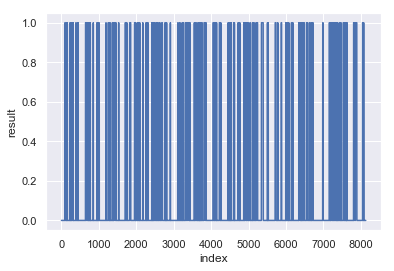

In [96]:
# do some visualization with result column
# we result to be evenly distributed
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

ax = sns.lineplot(x="index", 
                  y="result",
                  data=data)
plt.show()

In [97]:
# Correlation Matrix
corrmat = data.corr()
corrmat.round(2)

,rg,h,l,c1,c2,c3,supp,o_s,p_s,obv1,obv2,obv3,rsi1,rsi2,rsi3,natr,cyc,result,index
rg,1.00,0.02,0.02,0.02,0.02,0.02,0.02,-0.20,-0.10,-0.02,-0.00,0.02,-0.34,-0.24,-0.22,0.04,-0.08,0.11,0.03
h,0.02,1.00,1.00,1.00,1.00,1.00,1.00,-0.03,-0.11,0.04,0.05,0.03,-0.02,0.03,-0.02,0.26,0.18,-0.05,-0.03
l,0.02,1.00,1.00,1.00,1.00,1.00,1.00,-0.03,-0.11,0.04,0.05,0.03,-0.02,0.03,-0.02,0.26,0.18,-0.05,-0.03
c1,0.02,1.00,1.00,1.00,1.00,1.00,1.00,-0.03,-0.11,0.04,0.05,0.03,-0.02,0.03,-0.02,0.26,0.18,-0.05,-0.03
c2,0.02,1.00,1.00,1.00,1.00,1.00,1.00,-0.03,-0.11,0.04,0.05,0.03,-0.02,0.03,-0.02,0.26,0.18,-0.05,-0.03
c3,0.02,1.00,1.00,1.00,1.00,1.00,1.00,-0.03,-0.11,0.04,0.05,0.03,-0.02,0.03,-0.02,0.26,0.18,-0.05,-0.03
supp,0.02,1.00,1.00,1.00,1.00,1.00,1.00,-0.03,-0.11,0.04,0.05,0.03,-0.02,0.03,-0.02,0.26,0.18,-0.05,-0.03
o_s,-0.20,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,1.00,0.05,0.20,0.23,0.25,0.03,0.11,0.13,0.01,-0.06,-0.01,-0.02
p_s,-0.10,-0.11,-0.11,-0.11,-0.11,-0.11,-0.11,0.05,1.00,-0.08,-0.07,-0.06,0.00,0.19,0.24,-0.32,-0.20,0.02,0.09
obv1,-0.02,0.04,0.04,0.04,0.04,0.04,0.04,0.20,-0.08,1.00,0.98,0.95,0.19,0.25,0.17,0.02,0.01,-0.01,-0.00


In [98]:
X = data[['rg', 'h', 'l', 'c1', 'c2', 'c3', 'supp', 'o_s', 'p_s', 'obv1', 'obv2', 'obv3', 'rsi1', 'rsi2', 'rsi3', 'natr', 'cyc']]
y = data['result']

sc = MinMaxScaler()
X = sc.fit_transform(X)

# save sc so we can use it for predictions
scaler_filename = "scaler.save"
joblib.dump(sc, scaler_filename)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

neg = pos = 0
for val in y_test:
    if val < 0.5:
        neg += 1
    else:
        pos += 1
print("pos:", pos, " | neg:", neg)

pos: 252  | neg: 1375


In [99]:
# build a logistic regression model
# Posted accuracy of .75 - .83 
# accuracy not meaningful because of unbalanced nature of dataset

from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.8451137062077443


In [100]:
# Build the deep neural net: Posted Accuracy of .9 on train, .85 on test

# Number of neurons in the first layer = number of columns in dataset
# Activation function = ReLU
# 5 Hidden layers for a total of 6 layers in the network
# Last layer activation function = Sigmoid

class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(y_train), 
                                                  y_train)

model = Sequential()

# input layer
model.add(Dense(100, activation='relu', input_dim = 17))
          
# second layer
model.add(Dense(60, activation='relu'))
          
# third layer
model.add(Dense(60, activation='relu'))
          
# fourth layer
model.add(Dense(60, activation='relu'))

# fith layer
model.add(Dense(60, activation='relu'))
          
# output layer
model.add(Dense(1, activation='sigmoid'))

# compile the model using rmsprop opt and mse loss
model.compile(optimizer = 'rmsprop',     
              loss = 'mse',
              metrics = ['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y_train, 
                    validation_split = 0.33, 
                    epochs = 100,
                    class_weight = class_weights,
                    batch_size = 25)

# Evaluate the model's performance
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

Train on 4360 samples, validate on 2148 samples
Epoch 1/100
4360/4360 [==============================] - 1s 311us/step - loss: 0.1422 - acc: 0.8278 - val_loss: 0.1416 - val_acc: 0.8217
Epoch 2/100
4360/4360 [==============================] - 1s 142us/step - loss: 0.1371 - acc: 0.8278 - val_loss: 0.1686 - val_acc: 0.8217
Epoch 3/100
4360/4360 [==============================] - 1s 135us/step - loss: 0.1360 - acc: 0.8278 - val_loss: 0.1335 - val_acc: 0.8217
Epoch 4/100
4360/4360 [==============================] - 0s 108us/step - loss: 0.1321 - acc: 0.8287 - val_loss: 0.1345 - val_acc: 0.8226
Epoch 5/100
4360/4360 [==============================] - 1s 127us/step - loss: 0.1298 - acc: 0.8310 - val_loss: 0.1316 - val_acc: 0.8203
Epoch 6/100
4360/4360 [==============================] - 1s 128us/step - loss: 0.1269 - acc: 0.8353 - val_loss: 0.1286 - val_acc: 0.8287
Epoch 7/100
4360/4360 [==============================] - 1s 124us/step - loss: 0.1245 - acc: 0.8408 - val_loss: 0.1398 - val_acc: 

4360/4360 [==============================] - 1s 154us/step - loss: 0.0638 - acc: 0.9227 - val_loss: 0.0867 - val_acc: 0.8962
Epoch 61/100
4360/4360 [==============================] - 1s 157us/step - loss: 0.0648 - acc: 0.9209 - val_loss: 0.0886 - val_acc: 0.8906
Epoch 62/100
4360/4360 [==============================] - 1s 125us/step - loss: 0.0625 - acc: 0.9232 - val_loss: 0.0912 - val_acc: 0.8850
Epoch 63/100
4360/4360 [==============================] - 1s 141us/step - loss: 0.0622 - acc: 0.9220 - val_loss: 0.1028 - val_acc: 0.8608
Epoch 64/100
4360/4360 [==============================] - 0s 107us/step - loss: 0.0604 - acc: 0.9264 - val_loss: 0.0824 - val_acc: 0.9008
Epoch 65/100
4360/4360 [==============================] - 0s 110us/step - loss: 0.0621 - acc: 0.9239 - val_loss: 0.0773 - val_acc: 0.9060
Epoch 66/100
4360/4360 [==============================] - 0s 114us/step - loss: 0.0591 - acc: 0.9271 - val_loss: 0.0814 - val_acc: 0.8990
Epoch 67/100
4360/4360 [=======================

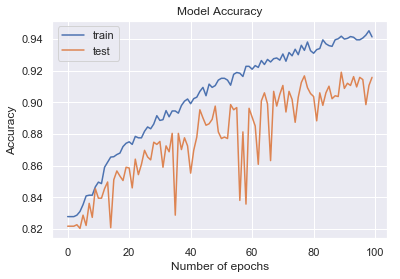

In [101]:
# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

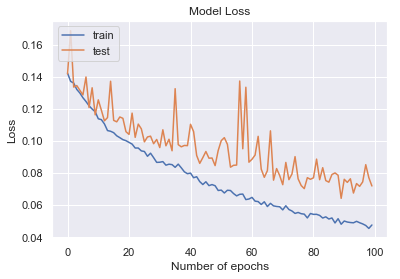

In [102]:
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 100)               1800      
_________________________________________________________________
dense_26 (Dense)             (None, 60)                6060      
_________________________________________________________________
dense_27 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_28 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_29 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 61        
Total params: 18,901
Trainable params: 18,901
Non-trainable params: 0
_________________________________________________________________


In [104]:
predictions = model.predict(X_test)
neg = pos = 0
for pred in predictions:
    if pred < 0.5:
        neg += 1
    else:
        pos += 1
print("pos:", pos, " | neg:", neg)
print(len(X_test))

pos: 203  | neg: 1424
1627


In [105]:
# save the model for later use

from keras.models import load_model
model.save('DNN_Breakout')  # creates a HDF5 file
del model  # deletes the existing model

# load model to make sure that it was correctly saved
model = load_model('DNN_Breakout')

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test set accuracy:', test_acc)

1627/1627 [==============================] - 0s 130us/step
Test set accuracy: 0.929317763119881
